In [1]:
%load_ext autoreload
%autoreload 2

## Experiments

Imports

In [2]:
# imports
import os, sys

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

from src import visualizations as v
from src import functions as f
from src import classes as c 

import pandas as pd
import numpy as np
from numpy.random import default_rng

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance


from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline 

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')
pd.options.display.max_rows = 300

## Loading the Augmented Modeling Data

In [3]:
path = os.path.join(gparent, 'data/processed', 'report_aug.csv')
df = pd.read_csv(path, encoding='unicode_escape')

## Modeling Objects
<font size="4">Instantiating various objects needed in the modeling process.</font>

In [4]:
rng = default_rng()

# creating f1 scorer
f1 = f.f1

# creating Harness
modeling = c.Harness(f1)

# creating tfidf instance
tfidf = TfidfVectorizer()

# creating oversampler instance
oversample = RandomOverSampler(sampling_strategy='minority', random_state=2021)

# creating SMOTE instance
sm = SMOTE(random_state=2021)

## Loading Data

In [5]:
path = os.path.join(gparent, 'data/processed', 'report_aug.csv')
df = pd.read_csv(path, encoding='unicode_escape')

## Splitting `data` & `target` and Creating Train-Test Split
<font size="4">`y_lem_aug` column values = {1: 'negative', 0: 'positive'}</font>

In [6]:
# Creating data & target
X_lem_aug = df.X_lem_aug
y_lem_aug = df.y_lem_aug

## Creating Modeling & Holdout Data

<font size="4"> Creating holdout data for testing. X_lem_testing and y_lem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original lemmatized data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [7]:
X_lem_training, X_lem_testing, y_lem_training, y_lem_testing = f.splitter(X_lem_aug,
                                                                           y_lem_aug)

In [8]:
# checking sizes
print(len(X_lem_training))
print(len(y_lem_training))
print(len(X_lem_testing))
print(len(y_lem_testing))

4403
4403
1468
1468


<font size="4">Splitting the X_lem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_lem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [9]:
X_lem_train, X_lem_val, y_lem_train, y_lem_val = f.splitter(X_lem_training,
                                                             y_lem_training)

In [10]:
# checking sizes
print(len(X_lem_train))
print(len(y_lem_train))
print(len(X_lem_val))
print(len(y_lem_val))

3302
3302
1101
1101


## XGBoost

## Baseline XGBoost CLF

In [11]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, random_state=2021)

In [12]:
steps = [('tfidf', tfidf), ('clf', xgb_clf)]
x_boost = Pipeline(steps=steps)
x_boost.fit(X_lem_train, y_lem_train)

[00:11:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=2021,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=None))])

In [13]:
modeling.report(x_boost, X_lem_train, y_lem_train, 'x_boost', 'xgb_baseline')

[00:11:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:11:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:11:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

array([0.86312399, 0.88924559, 0.86119874, 0.88253968, 0.88424437])

## Validation Metrics

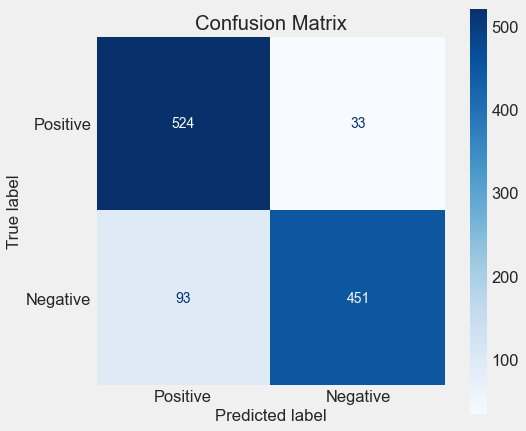

F1    Recall  Precision
0  0.877432  0.829044   0.931818

In [14]:
f.confusion_report(x_boost, X_lem_val, y_lem_val)

## Metrics
F1=0.877432, Recall=0.829044, Precision=0.931818

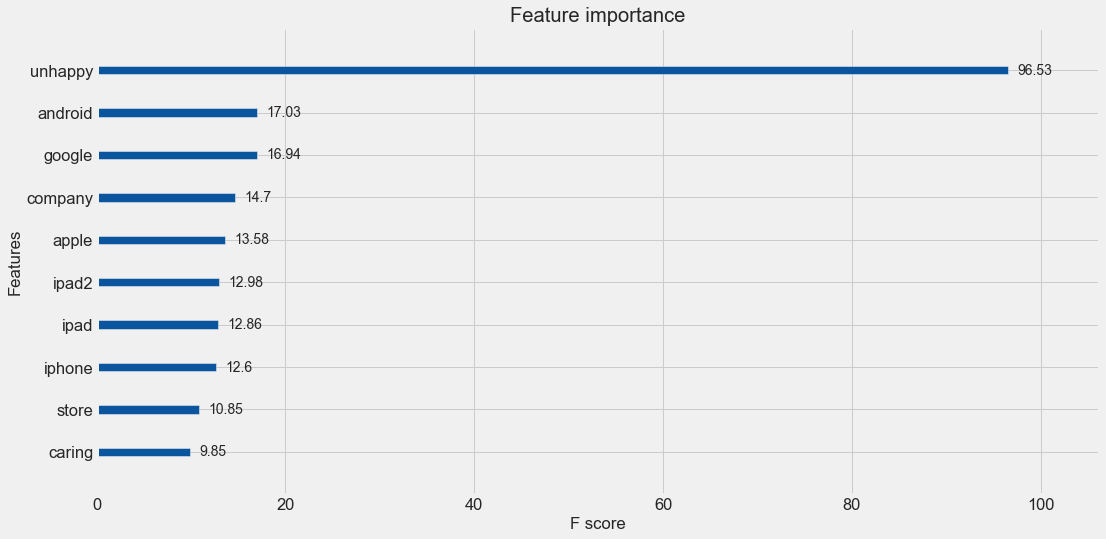

In [15]:
# setting feature names for the plot
x_boost[1].get_booster().feature_names = x_boost[0].get_feature_names()

# grabbing the booster
booster = x_boost[1].get_booster()

# grabbing importance dictionary
importance = booster.get_score(importance_type="gain")

# rounding values
for key in importance.keys():
    importance[key] = round(importance[key],2)

# plotting
fig, ax=plt.subplots(figsize=(16,8))
plot_importance(importance, ax=ax, max_num_features=10, importance_type='gain', show_values=True)
plt.show()

In [16]:
fig, ax=plt.subplots(figsize=(500,250))
xgb.plot_tree(x_boost[1], ax=ax, num_trees=0)
plt.show()

## Tuning CLF

## Pipeline

In [17]:
xgb_tune = xgb.XGBClassifier(use_label_encoder=False,
                             random_state = 2021)

steps = [('tfidf', tfidf), ('clf', xgb_tune)]

xgb_hyp = Pipeline(steps=steps)

## RandomizedSearchCV

In [18]:
# # setting ngram list
# ngram_range = [(1, i) for i in range(1, 5)]

# params = { 'tfidf__ngram_range': ngram_range,
#            'tfidf__use_idf': (True, False),
#            'clf__max_depth': [3, 5, 6, 10, 15, 20],
#            'clf__learning_rate': rng.uniform(.01, .5, 5),
#            'clf__subsample': rng.uniform(0.5, 1.0, 5),
#            'clf__colsample_bytree': np.arange(0.4, 1.0, 0.1),
#            'clf__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
#            'clf__n_estimators': range(50, 550, 100)}

# clf = RandomizedSearchCV(estimator=xgb_hyp,
#                          param_distributions=params,
#                          scoring='f1',
#                          n_iter=25,
#                          n_jobs=-1,
#                          verbose=2)

# clf.fit(X_lem_train, y_lem_train)

# print("Best parameters:", clf.best_params_)
# print("Best F1: ", clf.best_score_)

In [19]:
# setting best estimator
# tuned_xgb = clf.best_estimator_

## Saving Results
Saving results so we can run the notebook without doing the RandomizedSearchCV again.

In [20]:
# params_list = clf.cv_results_["params"]
# scores = clf.cv_results_["mean_test_score"]

In [21]:
# saving params 
params = [{'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.9849698976787964,
  'clf__n_estimators': 350,
  'clf__max_depth': 3,
  'clf__learning_rate': 0.028169960516459862,
  'clf__colsample_bytree': 0.4,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 2),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 350,
  'clf__max_depth': 3,
  'clf__learning_rate': 0.4850212554551075,
  'clf__colsample_bytree': 0.7999999999999999,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.8978933059683466,
  'clf__n_estimators': 50,
  'clf__max_depth': 5,
  'clf__learning_rate': 0.4316946669556227,
  'clf__colsample_bytree': 0.6,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.9849698976787964,
  'clf__n_estimators': 350,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.15953774893001285,
  'clf__colsample_bytree': 0.8999999999999999,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 3),
  'clf__subsample': 0.8915928832377631,
  'clf__n_estimators': 450,
  'clf__max_depth': 6,
  'clf__learning_rate': 0.028169960516459862,
  'clf__colsample_bytree': 0.6,
  'clf__colsample_bylevel': 0.7999999999999999},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 2),
  'clf__subsample': 0.8978933059683466,
  'clf__n_estimators': 150,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.4316946669556227,
  'clf__colsample_bytree': 0.4,
  'clf__colsample_bylevel': 0.4},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 1),
  'clf__subsample': 0.9849698976787964,
  'clf__n_estimators': 350,
  'clf__max_depth': 3,
  'clf__learning_rate': 0.028169960516459862,
  'clf__colsample_bytree': 0.6,
  'clf__colsample_bylevel': 0.7},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 1),
  'clf__subsample': 0.8978933059683466,
  'clf__n_estimators': 350,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.028169960516459862,
  'clf__colsample_bytree': 0.5,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 250,
  'clf__max_depth': 15,
  'clf__learning_rate': 0.3157851227609622,
  'clf__colsample_bytree': 0.4,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 1),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 450,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.4316946669556227,
  'clf__colsample_bytree': 0.7,
  'clf__colsample_bylevel': 0.7},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 150,
  'clf__max_depth': 5,
  'clf__learning_rate': 0.3157851227609622,
  'clf__colsample_bytree': 0.7999999999999999,
  'clf__colsample_bylevel': 0.7},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 2),
  'clf__subsample': 0.8915928832377631,
  'clf__n_estimators': 450,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.15953774893001285,
  'clf__colsample_bytree': 0.6,
  'clf__colsample_bylevel': 0.4},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 3),
  'clf__subsample': 0.8978933059683466,
  'clf__n_estimators': 250,
  'clf__max_depth': 6,
  'clf__learning_rate': 0.15953774893001285,
  'clf__colsample_bytree': 0.4,
  'clf__colsample_bylevel': 0.4},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 2),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 450,
  'clf__max_depth': 3,
  'clf__learning_rate': 0.3157851227609622,
  'clf__colsample_bytree': 0.7,
  'clf__colsample_bylevel': 0.7},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.8978933059683466,
  'clf__n_estimators': 150,
  'clf__max_depth': 5,
  'clf__learning_rate': 0.3157851227609622,
  'clf__colsample_bytree': 0.6,
  'clf__colsample_bylevel': 0.6},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 3),
  'clf__subsample': 0.8978933059683466,
  'clf__n_estimators': 450,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.028169960516459862,
  'clf__colsample_bytree': 0.4,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 3),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 350,
  'clf__max_depth': 6,
  'clf__learning_rate': 0.15953774893001285,
  'clf__colsample_bytree': 0.7,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 2),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 150,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.4316946669556227,
  'clf__colsample_bytree': 0.4,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 3),
  'clf__subsample': 0.8915928832377631,
  'clf__n_estimators': 250,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.3157851227609622,
  'clf__colsample_bytree': 0.8999999999999999,
  'clf__colsample_bylevel': 0.5},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 2),
  'clf__subsample': 0.9849698976787964,
  'clf__n_estimators': 450,
  'clf__max_depth': 20,
  'clf__learning_rate': 0.15953774893001285,
  'clf__colsample_bytree': 0.6,
  'clf__colsample_bylevel': 0.8999999999999999},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.8915928832377631,
  'clf__n_estimators': 250,
  'clf__max_depth': 20,
  'clf__learning_rate': 0.15953774893001285,
  'clf__colsample_bytree': 0.6,
  'clf__colsample_bylevel': 0.4},
 {'tfidf__use_idf': False,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 250,
  'clf__max_depth': 10,
  'clf__learning_rate': 0.3157851227609622,
  'clf__colsample_bytree': 0.7999999999999999,
  'clf__colsample_bylevel': 0.4},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 4),
  'clf__subsample': 0.8915928832377631,
  'clf__n_estimators': 150,
  'clf__max_depth': 5,
  'clf__learning_rate': 0.4850212554551075,
  'clf__colsample_bytree': 0.8999999999999999,
  'clf__colsample_bylevel': 0.4},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 3),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 250,
  'clf__max_depth': 6,
  'clf__learning_rate': 0.4316946669556227,
  'clf__colsample_bytree': 0.5,
  'clf__colsample_bylevel': 0.7999999999999999},
 {'tfidf__use_idf': True,
  'tfidf__ngram_range': (1, 2),
  'clf__subsample': 0.9926009399652742,
  'clf__n_estimators': 50,
  'clf__max_depth': 15,
  'clf__learning_rate': 0.028169960516459862,
  'clf__colsample_bytree': 0.6,
  'clf__colsample_bylevel': 0.4}]

In [22]:
# saving scores
scores = np.array([0.8480393 , 0.87381837, 0.86554458, 0.8742417 , 0.87217505,
       0.87557885, 0.86351348, 0.88191702, 0.87153065, 0.87333046,
       0.87322496, 0.87646287, 0.87911376, 0.87950243, 0.86590612,
       0.87817528, 0.87611077, 0.88261812, 0.86741645, 0.88204542,
       0.87114124, 0.86970715, 0.87020325, 0.86485986, 0.86981951])

In [23]:
# results_df = pd.concat([pd.DataFrame(clf.cv_results_["params"]),
#                         pd.DataFrame(clf.cv_results_["mean_test_score"],
#                                      columns=["F1 Accuracy"])],axis=1)

In [24]:
results_df = pd.concat([pd.DataFrame(params),
                        pd.DataFrame(scores,
                                     columns=["F1 Accuracy"])],axis=1)

In [25]:
results_df.sort_values(by=['F1 Accuracy'], ascending=False).head()

tfidf__use_idf tfidf__ngram_range  clf__subsample  clf__n_estimators  \
17           False             (1, 2)        0.992601                150   
19           False             (1, 2)        0.984970                450   
7             True             (1, 1)        0.897893                350   
13           False             (1, 2)        0.992601                450   
12           False             (1, 3)        0.897893                250   

    clf__max_depth  clf__learning_rate  clf__colsample_bytree  \
17              10            0.431695                    0.4   
19              20            0.159538                    0.6   
7               10            0.028170                    0.5   
13               3            0.315785                    0.7   
12               6            0.159538                    0.4   

    clf__colsample_bylevel  F1 Accuracy  
17                     0.5     0.882618  
19                     0.9     0.882045  
7                      0.5     0.881917  
13                     0.7     0.879502  
12                     0.4     0.879114

## Best XGB Model

In [26]:
# clf.best_estimator_.get_params()['steps']

In [27]:
saved_steps = [('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
               ('clf', XGBClassifier(base_score=0.5, booster='gbtree', 
                                     colsample_bylevel=0.5, colsample_bynode=1,
                                     colsample_bytree=0.4,gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.4316946669556227,
                                     max_delta_step=0, max_depth=10,
                                     min_child_weight=1, 
                                     monotone_constraints='()',
                                     n_estimators=150, n_jobs=8,
                                     num_parallel_tree=1, random_state=2021,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1,
                                     subsample=0.9926009399652742,
                                     tree_method='exact',
                                     use_label_encoder=False,
                                     validate_parameters=1, verbosity=None))]

In [28]:
tuned_x = Pipeline(steps=saved_steps)
tuned_x.fit(X_lem_train, y_lem_train)

[00:11:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=0.5, colsample_bynode=1,
                               colsample_bytree=0.4, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.4316946669556227,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=150,
                               n_jobs=8, num_parallel_tree=1, random_state=2021,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.9926009399652742,
                               tree_method='exact', use_label_encoder=False,
      

## Validation Metrics

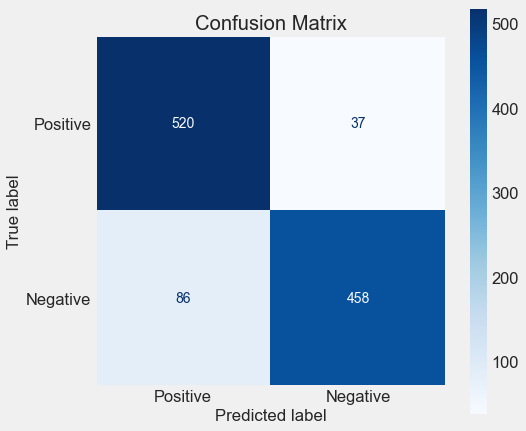

F1    Recall  Precision
0  0.881617  0.841912   0.925253

In [29]:
f.confusion_report(tuned_x, X_lem_val, y_lem_val)

<font size="4">F1=0.881617, Recall=0.841912, Precision=0.925253</font>

## Features

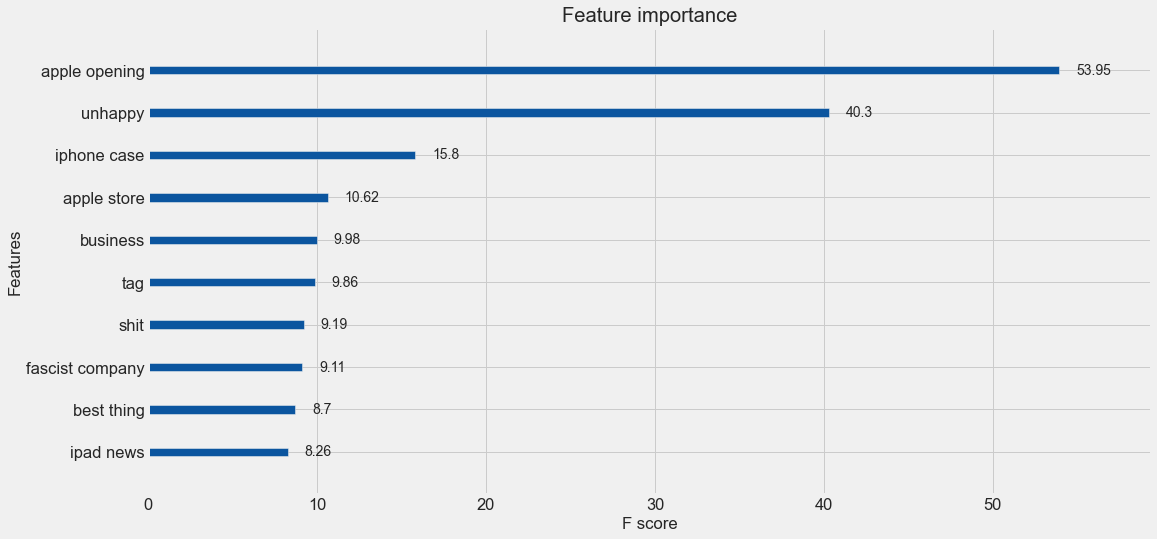

In [30]:
# setting feature names for the plot
tuned_x[1].get_booster().feature_names = tuned_x[0].get_feature_names()

# grabbing the booster
booster = tuned_x[1].get_booster()

# grabbing importance dictionary
importance = booster.get_score(importance_type="gain")

# rounding values
for key in importance.keys():
    importance[key] = round(importance[key],2)

# plotting
fig, ax=plt.subplots(figsize=(16,8))
plot_importance(importance, ax=ax, max_num_features=10, importance_type='gain', show_values=True)
plt.show()

## Tree Plot

In [31]:
fig, ax=plt.subplots(figsize=(500,250))
xgb.plot_tree(tuned_x[1], ax=ax, num_trees=0)
plt.show()